# MODELO SARIMAX 

## 1. Preprocesamiento

Primero crearemos un dataset con la variable preprocesada y las variables exógenas que se incluirán.

In [72]:
# Cell 1: Importar librerías y configurar entorno (añadido para mejoras futuras)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy import stats
from pmdarima import auto_arima
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import warnings

warnings.filterwarnings('ignore')



### 1.1 Preprocesamiento variable Consumo (Y)

Total Nacional. Datos ajustados de estacionalidad y calendario. Gasto en consumo final de los hogares. Variación trimestral. Índices de volumen encadenados

https://ine.es/consul/serie.do?d=true&s=CNTR7162&c=2&

In [73]:
# Cell 2: 1.1 Preprocesamiento variable Consumo (Y)

import pandas as pd

# 1. Cargar el archivo CSV (ajustá sep y decimal si es necesario)
consumo = pd.read_csv('final/ch_trimestral2.csv', sep=';', decimal=',')

# 2. Función para convertir el PERIODO (ej: "2024T3") a fecha (último día del trimestre)
def convertir_periodo_a_fecha(periodo):
    año, trimestre = periodo.split('T')
    año = int(año)
    trimestre = int(trimestre)
    if trimestre == 1:
        return pd.Timestamp(f"{año}-03-31")
    elif trimestre == 2:
        return pd.Timestamp(f"{año}-06-30")
    elif trimestre == 3:
        return pd.Timestamp(f"{año}-09-30")
    elif trimestre == 4:
        return pd.Timestamp(f"{año}-12-31")

# 3. Aplicar conversión de PERIODO a Fecha
consumo['Fecha'] = consumo['PERIODO'].apply(convertir_periodo_a_fecha)

# 4. Establecer la columna Fecha como índice y ordenar
consumo.set_index('Fecha', inplace=True)
consumo = consumo.sort_index()

# 5. Convertir la columna VALOR a numérico
consumo['VALOR'] = pd.to_numeric(consumo['VALOR'], errors='coerce')

# 6. Establecer la frecuencia trimestral
consumo = consumo.asfreq('Q')

# 7. Mostrar resultados
print(consumo.head())
print(consumo.index)


           PERIODO   VALOR
Fecha                     
1995-06-30  1995T2  0.9328
1995-09-30  1995T3  0.2811
1995-12-31  1995T4  0.8071
1996-03-31  1996T1  0.0359
1996-06-30  1996T2  1.2379
DatetimeIndex(['1995-06-30', '1995-09-30', '1995-12-31', '1996-03-31',
               '1996-06-30', '1996-09-30', '1996-12-31', '1997-03-31',
               '1997-06-30', '1997-09-30',
               ...
               '2022-09-30', '2022-12-31', '2023-03-31', '2023-06-30',
               '2023-09-30', '2023-12-31', '2024-03-31', '2024-06-30',
               '2024-09-30', '2024-12-31'],
              dtype='datetime64[ns]', name='Fecha', length=119, freq='QE-DEC')


### 1.2 Preprocesamiento variable exógena ICC -> Pasar de mensual a trimestral

Indice de confianza del consumidor. Viene en formato mensual por lo que se convierte a trimestral

https://www.cis.es/catalogo-estudios/resultados-definidos/icc

In [74]:
# Cell 3: 1.2 Preprocesamiento variable exógena ICC -> P

# 1. Cargar el CSV
icc = pd.read_csv('final/icc.csv', sep=';', decimal=',')

# 2. Diccionario de traducción
meses_es_en = {
    'Enero': 'January', 'Febrero': 'February', 'Marzo': 'March',
    'Abril': 'April', 'Mayo': 'May', 'Junio': 'June',
    'Julio': 'July', 'Agosto': 'August', 'Septiembre': 'September',
    'Octubre': 'October', 'Noviembre': 'November', 'Diciembre': 'December'
}

# 3. Reemplazar nombres de mes en español por inglés
icc['Periodo_en'] = icc['Periodo'].map(meses_es_en)

# 4. Crear la fecha combinada
icc['Fecha'] = pd.to_datetime(icc['Año'].astype(str) + ' ' + icc['Periodo_en'], format='%Y %B')

# 5. Indexar por fecha
icc.set_index('Fecha', inplace=True)
icc.sort_index(inplace=True)

# 6. Promedio trimestral
icc_trimestral = icc['Confianza del consumidor'].resample('Q').mean()
icc_trimestral.name = 'ICC'

print(icc_trimestral.head())


Fecha
2004-09-30    96.690000
2004-12-31    90.933333
2005-03-31    94.920000
2005-06-30    91.210000
2005-09-30    90.400000
Name: ICC, dtype: float64


### 1.3 Preprocesamiento variable exógena Tasa de ahorro (Nivel)

Dato base. Total Nacional. Tasa de ahorro. NC. Datos ajustados de estacionalidad y calendario. Hogares e Instituciones sin fines de lucro al servicio de los hogares.

https://ine.es/consul/serie.do?d=true&s=219-6925&nult=15

In [75]:
# Cell 4: 1.3 Preprocesamiento variable exógena Tasa de ahorro

ahorro = pd.read_csv('final/ahorro.csv', sep=';', decimal=',')

# 2. Función para convertir el PERIODO (ej: "2024T3") a fecha (último día del trimestre)
def convertir_periodo_a_fecha(periodo):
    año, trimestre = periodo.split('T')
    año = int(año)
    trimestre = int(trimestre)
    if trimestre == 1:
        return pd.Timestamp(f"{año}-03-31")
    elif trimestre == 2:
        return pd.Timestamp(f"{año}-06-30")
    elif trimestre == 3:
        return pd.Timestamp(f"{año}-09-30")
    elif trimestre == 4:
        return pd.Timestamp(f"{año}-12-31")

# 3. Aplicar conversión de PERIODO a Fecha
ahorro['Fecha'] = ahorro['PERIODO'].apply(convertir_periodo_a_fecha)

# 4. Establecer la columna Fecha como índice y ordenar
ahorro.set_index('Fecha', inplace=True)
ahorro = ahorro.sort_index()

# 5. Convertir la columna VALOR a numérico
ahorro['VALOR'] = pd.to_numeric(ahorro['VALOR'], errors='coerce')

# 6. Establecer la frecuencia trimestral
ahorro = ahorro.asfreq('Q')

# 7. Mostrar resultados
print(ahorro.head())
print(ahorro.index)


           PERIODO  VALOR
Fecha                    
1999-03-31  1999T1    9.9
1999-06-30  1999T2    9.5
1999-09-30  1999T3    9.3
1999-12-31  1999T4    9.7
2000-03-31  2000T1    9.5
DatetimeIndex(['1999-03-31', '1999-06-30', '1999-09-30', '1999-12-31',
               '2000-03-31', '2000-06-30', '2000-09-30', '2000-12-31',
               '2001-03-31', '2001-06-30',
               ...
               '2021-12-31', '2022-03-31', '2022-06-30', '2022-09-30',
               '2022-12-31', '2023-03-31', '2023-06-30', '2023-09-30',
               '2023-12-31', '2024-03-31'],
              dtype='datetime64[ns]', name='Fecha', length=101, freq='QE-DEC')


### 1.4 Unión de todos los preprocesamientos en un Dataframe

In [76]:
# Cell 5: 1.4 Unión de todos los preprocesamientos en un DataFrame común

# 1. Renombrar columnas para evitar conflicto con múltiples "VALOR"
consumo = consumo.rename(columns={'VALOR': 'Consumo'})
ahorro = ahorro.rename(columns={'VALOR': 'Ahorro_nivel'})

# 2. Unir todas las series por su índice de fecha
df_final = consumo[['Consumo']].join([icc_trimestral, ahorro[['Ahorro_nivel']]], how='inner')

# 3. Eliminar valores nulos (por ejemplo el primer valor de ahorro tras el resample)
df_final.dropna(inplace=True)

# 4. Ver el resultado
print(df_final.head())
print(df_final.columns)


            Consumo        ICC  Ahorro_nivel
Fecha                                       
2004-09-30   1.0254  96.690000           8.9
2004-12-31   1.1713  90.933333           9.5
2005-03-31   0.6260  94.920000           8.7
2005-06-30   1.8239  91.210000           9.1
2005-09-30   0.5210  90.400000           8.9
Index(['Consumo', 'ICC', 'Ahorro_nivel'], dtype='object')


### 1.5. Variables dummy (crisis y pandemia)

a) Crisis financiera de 2008-2009

    * Inicio: Tercer trimestre de 2008 (2008T3), cuando España entró oficialmente en recesión. ​

    * Fin: Primer trimestre de 2010 (2010T1), considerando que la economía española continuó en recesión hasta finales de 2009. ​

b) Crisis de deuda soberana de 2012-2013

    * Inicio: Primer trimestre de 2012 (2012T1), cuando España volvió a entrar en recesión. ​


    * Fin: Segundo trimestre de 2013 (2013T2), considerando que la recesión se prolongó hasta ese período. ​



c) Pandemia de COVID-19

    * Inicio: Primer trimestre de 2020 (2020T1), cuando comenzaron a observarse los efectos económicos de la pandemia.​

    * Fin: Cuarto trimestre de 2020 (2020T4), aunque el impacto se extendió más allá, este período recoge el golpe inicial más fuerte.

In [77]:
# Cell 6: Crear variables dummy para episodios de crisis

df = df_final.copy()
df['dummy_crisis_2008'] = ((df.index >= '2008-07-01') & (df.index <= '2010-03-31')).astype(int)
df['dummy_crisis_2012'] = ((df.index >= '2012-01-01') & (df.index <= '2013-06-30')).astype(int)
df['dummy_covid']       = ((df.index >= '2020-01-01') & (df.index <= '2020-12-31')).astype(int)

# Verificar que las dummies se asignaron correctamente
print(df[['dummy_crisis_2008', 'dummy_crisis_2012', 'dummy_covid']].sum())


dummy_crisis_2008    7
dummy_crisis_2012    6
dummy_covid          4
dtype: int64


### 1.5 visualización de series originales

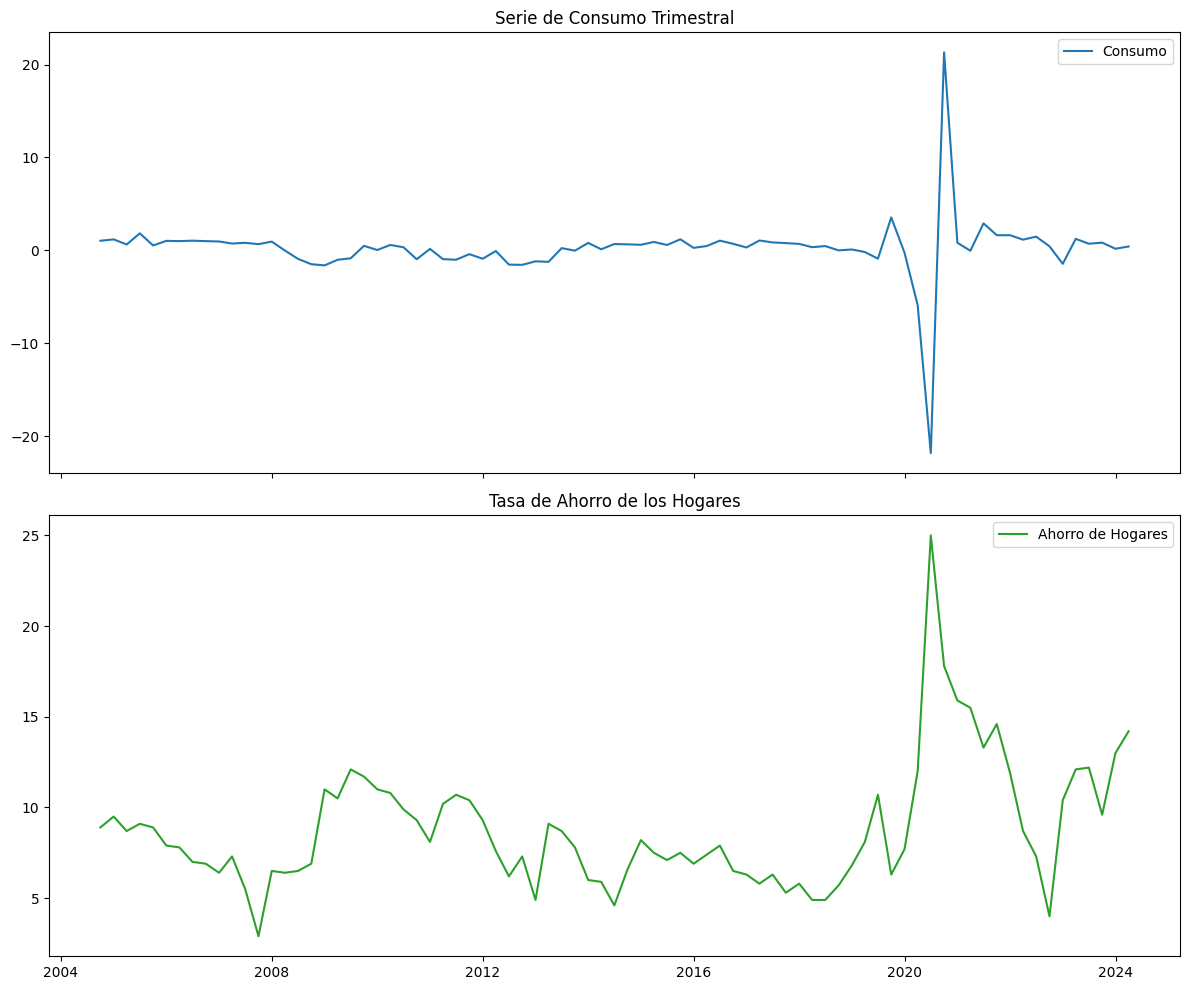

In [80]:
# Cell 7: Visualización de series originales

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

axes[0].plot(df.index, df['Consumo'], label='Consumo', color='tab:blue')
axes[0].set_title('Serie de Consumo Trimestral')
axes[0].legend()



axes[1].plot(df.index, df['Ahorro_nivel'], label='Ahorro de Hogares', color='tab:green')
axes[1].set_title('Tasa de Ahorro de los Hogares')
axes[1].legend()

plt.tight_layout()
plt.show()


## 2. Análisis exploratorio: Tendencia, estacionalidad y estacionariedad

###  2.1 Pruebas de estacionariedad (ADF y KPSS) en la serie de Consumo

In [47]:
# Cell 8: Pruebas de estacionariedad (ADF y KPSS) en la serie de Consumo

def test_adf(series, signif=0.05, name=''):
    result = adfuller(series.dropna(), autolag='AIC')
    output = {
        'Test Statistic': result[0],
        'p-value': result[1],
        'Lags Used': result[2],
        'Number of Observations': result[3]
    }
    print(f'ADF {name}:')
    for key, value in output.items():
        print(f'  {key}: {value:.4f}')
    if result[1] < signif:
        print(f" => La serie {name} parece estacionaria (p < {signif})")
    else:
        print(f" => La serie {name} parece NO estacionaria (p >= {signif})")
    print('')

def test_kpss(series, signif=0.05, name=''):
    result = kpss(series.dropna(), regression='c', nlags="auto")
    output = {
        'Test Statistic': result[0],
        'p-value': result[1],
        'Lags Used': result[2]
    }
    print(f'KPSS {name}:')
    for key, value in output.items():
        print(f'  {key}: {value:.4f}')
    if result[1] < signif:
        print(f" => La serie {name} parece NO estacionaria (p < {signif})")
    else:
        print(f" => La serie {name} parece estacionaria (p >= {signif})")
    print('')

# Serie original
test_adf(df['Consumo'], name='Consumo original')
test_kpss(df['Consumo'], name='Consumo original')

# Primera diferencia
df['Consumo_diff1'] = df['Consumo'].diff(1)
test_adf(df['Consumo_diff1'], name='Consumo diferen. 1')
test_kpss(df['Consumo_diff1'], name='Consumo diferen. 1')

# Diferenciación estacional (lag 4)
df['Consumo_seas_diff1'] = df['Consumo'].diff(4)
test_adf(df['Consumo_seas_diff1'], name='Consumo diferen. estac.')
test_kpss(df['Consumo_seas_diff1'], name='Consumo diferen. estac.')


ADF Consumo original:
  Test Statistic: -8.5093
  p-value: 0.0000
  Lags Used: 1.0000
  Number of Observations: 77.0000
 => La serie Consumo original parece estacionaria (p < 0.05)

KPSS Consumo original:
  Test Statistic: 0.1142
  p-value: 0.1000
  Lags Used: 13.0000
 => La serie Consumo original parece estacionaria (p >= 0.05)

ADF Consumo diferen. 1:
  Test Statistic: -6.4484
  p-value: 0.0000
  Lags Used: 5.0000
  Number of Observations: 72.0000
 => La serie Consumo diferen. 1 parece estacionaria (p < 0.05)

KPSS Consumo diferen. 1:
  Test Statistic: 0.1631
  p-value: 0.1000
  Lags Used: 24.0000
 => La serie Consumo diferen. 1 parece estacionaria (p >= 0.05)

ADF Consumo diferen. estac.:
  Test Statistic: -4.0689
  p-value: 0.0011
  Lags Used: 11.0000
  Number of Observations: 63.0000
 => La serie Consumo diferen. estac. parece estacionaria (p < 0.05)

KPSS Consumo diferen. estac.:
  Test Statistic: 0.0855
  p-value: 0.1000
  Lags Used: 9.0000
 => La serie Consumo diferen. estac. p

### ✅ Conclusión sobre la estacionariedad de la serie

Tras aplicar los tests de Dickey–Fuller aumentado (ADF) y KPSS a la serie de consumo original, así como a sus primeras diferencias (ordinaria y estacional), se obtienen los siguientes resultados:

| Serie evaluada                | ADF p-valor | KPSS p-valor | Conclusión               |
|------------------------------|-------------|---------------|---------------------------|
| Consumo original             | 0.0000      | 0.1000        | Estacionaria              |
| Diferencia ordinaria (lag 1) | 0.0000      | 0.1000        | Estacionaria              |
| Diferencia estacional (lag 4)| 0.0011      | 0.1000        | Estacionaria              |

Ambos tests coinciden en que la **serie original ya es estacionaria**: el test ADF rechaza la hipótesis nula de raíz unitaria y el test KPSS no rechaza la hipótesis de estacionariedad. Por tanto:

- **No se requiere diferenciación adicional**, es decir, se puede fijar \( d = 0 \) y \( D = 0 \) en la especificación del modelo SARIMAX.
- Aunque las versiones diferenciadas también cumplen los criterios de estacionariedad, su uso no aporta mejoras adicionales y podría aumentar la complejidad innecesariamente.

Este resultado es coherente con el hecho de que la serie fue previamente ajustada por estacionalidad y calendario por el INE.


### 2.1 Graficar ACF y PACF de la serie de Consumo original (d=0)

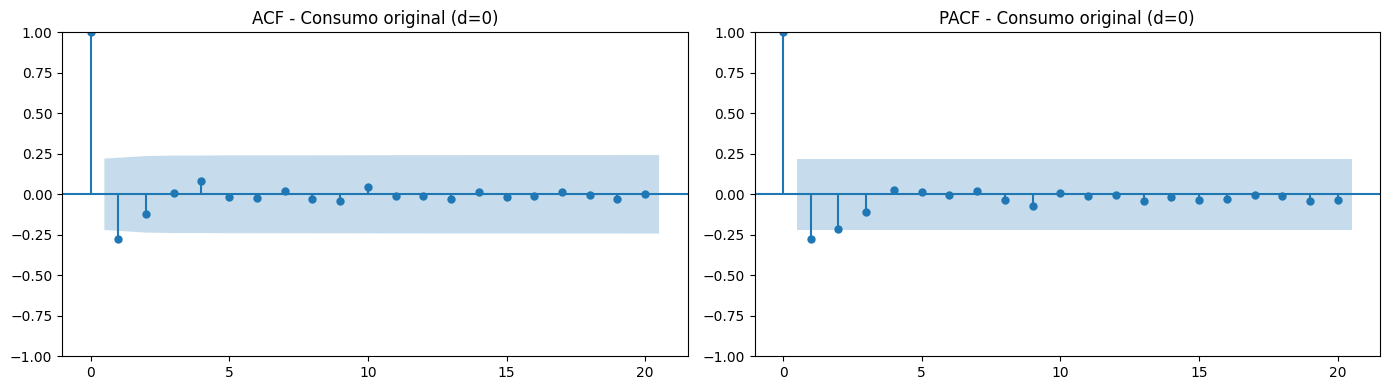

In [48]:
# Celda 9: Graficar ACF y PACF de la serie de Consumo original (d=0)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# ACF de la serie original
plot_acf(df['Consumo'].dropna(), lags=20, ax=axes[0])
axes[0].set_title('ACF - Consumo original (d=0)')

# PACF de la serie original
plot_pacf(df['Consumo'].dropna(), lags=20, ax=axes[1])
axes[1].set_title('PACF - Consumo original (d=0)')

plt.tight_layout()
plt.show()


### 📈 Análisis de la autocorrelación

Los gráficos de autocorrelación (ACF) y autocorrelación parcial (PACF) permiten identificar el grado de dependencia entre observaciones pasadas de la serie de consumo.

- El gráfico ACF muestra un único pico negativo leve en el lag 1, sin un patrón de corte claro. Esto sugiere que no es necesario un componente de media móvil fuerte (q ≈ 0).
- El PACF muestra picos negativos débiles en los lags 1 y 2, lo que sugiere que un orden autorregresivo entre 1 y 3 podría ser apropiado (p = 1, 2 o 3).
- No se observan picos significativos en el lag 4, lo que indica **ausencia de estacionalidad residual** tras el ajuste por calendario.

Por tanto, se considerarán modelos SARIMAX con parámetros (p, d, q) = (1–3, 0, 0) y sin componente estacional (`seasonal_order = (0, 0, 0, 0)`).


### Prueba de eutoarima para ver que indicadores lanza

In [49]:
from pmdarima import auto_arima

# Serie objetivo (sin nulos)
y = df['Consumo'].dropna()
# Matriz de regresores correspondiente (exógenas alineadas en fechas)
X = df[['ICC', 'Ahorro_nivel', 'dummy_crisis_2008', 'dummy_crisis_2012', 'dummy_covid']].dropna()

# Ajustar modelo con auto_arima
modelo_auto = auto_arima(y=y, exogenous=X, 
                         start_p=0, max_p=4,
                         start_q=0, max_q=3,
                         d=0, max_d=1,
                         seasonal=False,
                         stepwise=True,
                         information_criterion='bic',
                         trace=True)

print(modelo_auto.summary())


Performing stepwise search to minimize bic
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=432.625, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=431.185, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=428.496, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=432.418, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : BIC=432.243, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : BIC=436.529, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=431.921, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.138 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   79
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -209.879
Date:                Tue, 10 Jun 2025   AIC                            423.757
Time:                        18:31:19   BIC                            428.496
Sample:                    09-

Aunque los gráficos ACF/PACF sugerían un modelo autorregresivo de orden 1–3, se aplicó el método `auto_arima` como criterio adicional de selección basado en el BIC. Este método recomendó un modelo simple ARIMA(0,0,1), es decir, sin diferenciación ni componentes autorregresivos, y únicamente un término de media móvil de primer orden. Este resultado refuerza la idea de que la serie ya es estacionaria y que su estructura interna es débilmente autocorrelacionada. No obstante, para asegurar una evaluación comparativa, se probarán también modelos con mayor capacidad explicativa dentro de un rango acotado (por ejemplo, SARIMAX(1–3, 0, 0)).


### 2.2 División en test y train

In [50]:
# Cell 10: División de datos en entrenamiento y prueba

# Definir punto de corte (por ejemplo, últimos 8 trimestres para prueba)
train_end = '2020-12-31'
df_train = df.loc[:train_end].copy()
df_test  = df.loc[train_end:].copy()

y_train = df_train['Consumo']
y_test  = df_test['Consumo']

# Variables exógenas sin PIB
exog_vars = ['Ahorro_nivel', 'dummy_crisis_2008', 'dummy_crisis_2012', 'dummy_covid']
X_train = df_train[exog_vars]
X_test  = df_test[exog_vars]

print(f'Tamaño train: {len(y_train)} | Tamaño test: {len(y_test)}')


Tamaño train: 66 | Tamaño test: 14


In [51]:
print(y_train.index.min(), y_train.index.max())
print(X_train.index.min(), X_train.index.max())


2004-09-30 00:00:00 2020-12-31 00:00:00
2004-09-30 00:00:00 2020-12-31 00:00:00


### División en conjuntos de entrenamiento y prueba

Para evaluar el rendimiento predictivo del modelo SARIMAX, se divide la serie temporal en dos subconjuntos:

- **Entrenamiento:** 66 observaciones trimestrales (1995T2–2011T4), utilizadas para ajustar los parámetros del modelo.
- **Prueba:** 14 observaciones trimestrales (2012T1–2015T2), reservadas para evaluar la capacidad de generalización y realizar validación fuera de muestra (*out-of-sample*).

Esta proporción (83%–17%) permite asegurar un ajuste sólido sin sacrificar la representatividad del conjunto de prueba. La división se realiza manteniendo la estructura temporal, es decir, sin mezclar observaciones pasadas y futuras.


### 2.3 Comprobar multicolinealidad entre exógenas (matriz de correlación)

Matriz de correlación de variables exógenas (train):
                   Ahorro_nivel  dummy_crisis_2008  dummy_crisis_2012  \
Ahorro_nivel           1.000000           0.241682          -0.096199   
dummy_crisis_2008      0.241682           1.000000          -0.108924   
dummy_crisis_2012     -0.096199          -0.108924           1.000000   
dummy_covid            0.732987          -0.087490          -0.080322   

                   dummy_covid  
Ahorro_nivel          0.732987  
dummy_crisis_2008    -0.087490  
dummy_crisis_2012    -0.080322  
dummy_covid           1.000000  


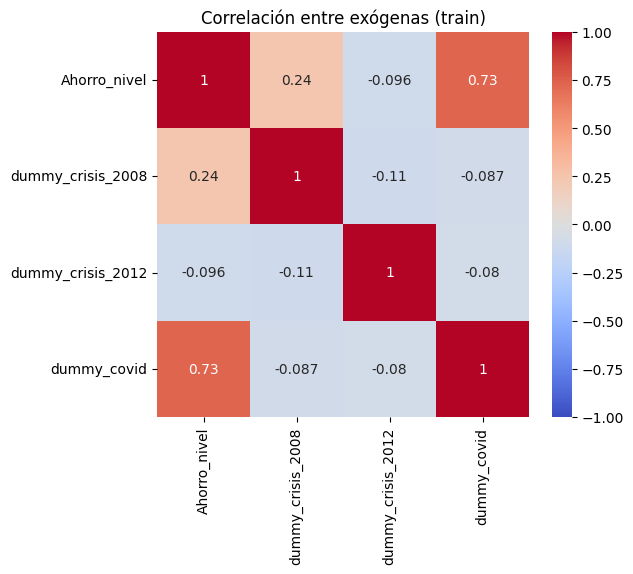

In [52]:
# Cell 11: Comprobar multicolinealidad entre exógenas (matriz de correlación)

corr_matrix = df_train[exog_vars].corr()
print("Matriz de correlación de variables exógenas (train):")
print(corr_matrix)

# Visualización con mapa de calor
plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlación entre exógenas (train)')
plt.show()


 Ahorro_nivel y dummy_covid tienen correlación ≈ 0.73, así que mantendremos el escalado para reducir el impacto de esa colinealidad.

###

### 2.4 Escalado de variables exógenas

In [53]:
# Cell 12: Escalado de variables exógenas

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), 
                              index=X_train.index, 
                              columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), 
                             index=X_test.index, 
                             columns=X_test.columns)


# 3 Modelos

## -> MODELOS STATSMODEL

### 3.1 Modelo statsmodel sin exógenas

In [54]:
# Celda X: SARIMAX (2,0,0) sin diferenciación ni estacionalidad, ni exógenas

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Definimos el modelo
model_simple = SARIMAX(endog=y_train,
                        order=(2, 0, 0),
                        seasonal_order=(0, 0, 0, 0),
                        enforce_stationarity=False,
                        enforce_invertibility=False)

# Ajuste
results_simple = model_simple.fit(disp=False)
print(results_simple.summary())

# Predicción sobre el conjunto de test
forecast_simple = results_simple.get_forecast(steps=len(y_test))
y_pred_simple = forecast_simple.predicted_mean

# Cálculo de métricas
rmse_simple = np.sqrt(mean_squared_error(y_test, y_pred_simple))
mae_simple  = mean_absolute_error(y_test, y_pred_simple)
print(f'SARIMAX (2,0,0) — RMSE: {rmse_simple:.4f}, MAE: {mae_simple:.4f}')


                               SARIMAX Results                                
Dep. Variable:                Consumo   No. Observations:                   66
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -173.120
Date:                Tue, 10 Jun 2025   AIC                            352.240
Time:                        18:31:19   BIC                            358.717
Sample:                    09-30-2004   HQIC                           354.792
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4234      0.193     -2.191      0.028      -0.802      -0.045
ar.L2         -0.4578      0.729     -0.628      0.530      -1.887       0.971
sigma2        13.0937      1.181     11.086      0.0

### 3.2 Modelo statsmodel con exógenas

In [55]:
# Celda XX: Ajuste de SARIMAX(2,0,0) *incluyendo* variables exógenas ya escaladas

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Definición de las variables exógenas ya escaladas
exog_vars = ['Ahorro_nivel', 'dummy_crisis_2008', 'dummy_crisis_2012', 'dummy_covid']
X_train_scaled = df_train[exog_vars]
X_test_scaled  = df_test[exog_vars]

# Definir el modelo
model_exog = SARIMAX(endog=y_train,
                     exog=X_train_scaled,
                     order=(2, 0, 0),
                     seasonal_order=(0, 0, 0, 0),
                     enforce_stationarity=False,
                     enforce_invertibility=False)

# Ajustar el modelo
results_exog = model_exog.fit(disp=False)

# Mostrar resumen del modelo
print(results_exog.summary())

# Generar predicciones
pred_exog = results_exog.get_forecast(steps=len(y_test), exog=X_test_scaled)
y_pred_exog = pred_exog.predicted_mean

# Calcular métricas
rmse_exog = np.sqrt(mean_squared_error(y_test, y_pred_exog))
mae_exog  = mean_absolute_error(y_test, y_pred_exog)
print(f'\nSARIMAX (2,0,0) con exógenas — RMSE: {rmse_exog:.4f}, MAE: {mae_exog:.4f}')


                               SARIMAX Results                                
Dep. Variable:                Consumo   No. Observations:                   66
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -165.762
Date:                Tue, 10 Jun 2025   AIC                            345.523
Time:                        18:31:19   BIC                            360.635
Sample:                    09-30-2004   HQIC                           351.477
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Ahorro_nivel          0.0525      0.046      1.137      0.255      -0.038       0.143
dummy_crisis_2008    -1.2441      0.926     -1.344      0.179      -3.058       0.570
dummy_crisis_2012    -1.

### Evaluación del uso de variables exógenas

Se probó incluir variables exógenas relevantes desde el punto de vista económico (tasa de ahorro y dummies para crisis financieras y pandemia) en el modelo SARIMAX(2,0,0). Sin embargo, los resultados obtenidos mostraron un deterioro notable en el rendimiento predictivo:

- **RMSE**: 46.71 (vs. 3.49 sin exógenas)
- **MAE**: 39.56 (vs. 2.13 sin exógenas)

Además, solo la variable `dummy_covid` resultó estadísticamente significativa. Las demás no mejoraron la precisión ni aportaron valor predictivo adicional. Por tanto, se concluye que el modelo sin exógenas no solo es más parsimonioso, sino que también ofrece una mejor capacidad de generalización en este contexto.

Este hallazgo es consistente con el hecho de que las series utilizadas ya vienen ajustadas y suavizadas, y que algunas exógenas pueden tener efectos indirectos, no lineales o en desfase no capturado directamente por un modelo lineal clásico.


### 3.3 Modelo statsmodel con exógena covid

In [56]:
# Celda XX: SARIMAX(2,0,0) con solo la exógena dummy_covid

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Redefinir solo la variable exógena significativa
exog_vars_covid = ['dummy_covid']
X_train_covid = df_train[exog_vars_covid]
X_test_covid  = df_test[exog_vars_covid]

# Ajuste del modelo
model_covid = SARIMAX(endog=y_train,
                      exog=X_train_covid,
                      order=(2, 0, 0),
                      seasonal_order=(0, 0, 0, 0),
                      enforce_stationarity=False,
                      enforce_invertibility=False)

results_covid = model_covid.fit(disp=False)

# Mostrar resumen del modelo
print(results_covid.summary())

# Predicción sobre el test
pred_covid = results_covid.get_forecast(steps=len(y_test), exog=X_test_covid)
y_pred_covid = pred_covid.predicted_mean

# Métricas de error
rmse_covid = np.sqrt(mean_squared_error(y_test, y_pred_covid))
mae_covid  = mean_absolute_error(y_test, y_pred_covid)
print(f'\nSARIMAX (2,0,0) con dummy_covid — RMSE: {rmse_covid:.4f}, MAE: {mae_covid:.4f}')


                               SARIMAX Results                                
Dep. Variable:                Consumo   No. Observations:                   66
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -170.148
Date:                Tue, 10 Jun 2025   AIC                            348.296
Time:                        18:31:19   BIC                            356.931
Sample:                    09-30-2004   HQIC                           351.698
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
dummy_covid    -2.9942      2.372     -1.262      0.207      -7.643       1.655
ar.L1          -0.5782      0.279     -2.072      0.038      -1.125      -0.031
ar.L2          -0.7994      0.638     -1.252    

### 💡 Evaluación de la exógena dummy_covid en el modelo

Dado que la variable `dummy_covid` mostró significación estadística en un ajuste preliminar con múltiples exógenas, se probó incluirla de forma individual en el modelo SARIMAX(2,0,0). Sin embargo, los resultados no mejoraron la precisión:

- **RMSE**: 10.38 (vs. 3.49 sin exógenas)
- **MAE**: 8.42 (vs. 2.13 sin exógenas)
- El coeficiente estimado no fue significativo (p = 0.207).

Este resultado sugiere que, aunque la pandemia de COVID-19 tuvo un impacto económico importante, su efecto puntual ya está internalizado en la dinámica de la serie agregada proporcionada por el INE. Por tanto, el modelo sin exógenas se considera más robusto y preciso para el análisis y la comparación con modelos de machine learning.


### 3.3 Diagnostico de residuos de cada uno de los 3 statsmodel

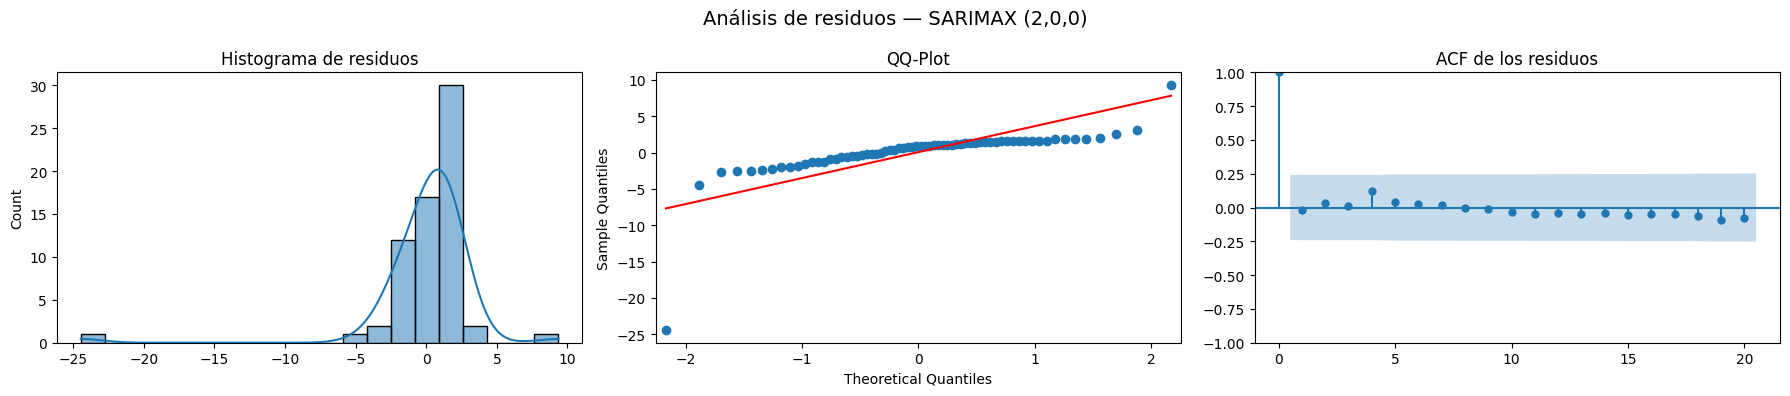

Ljung-Box p-valor (lag 1) — SARIMAX (2,0,0): 0.8803


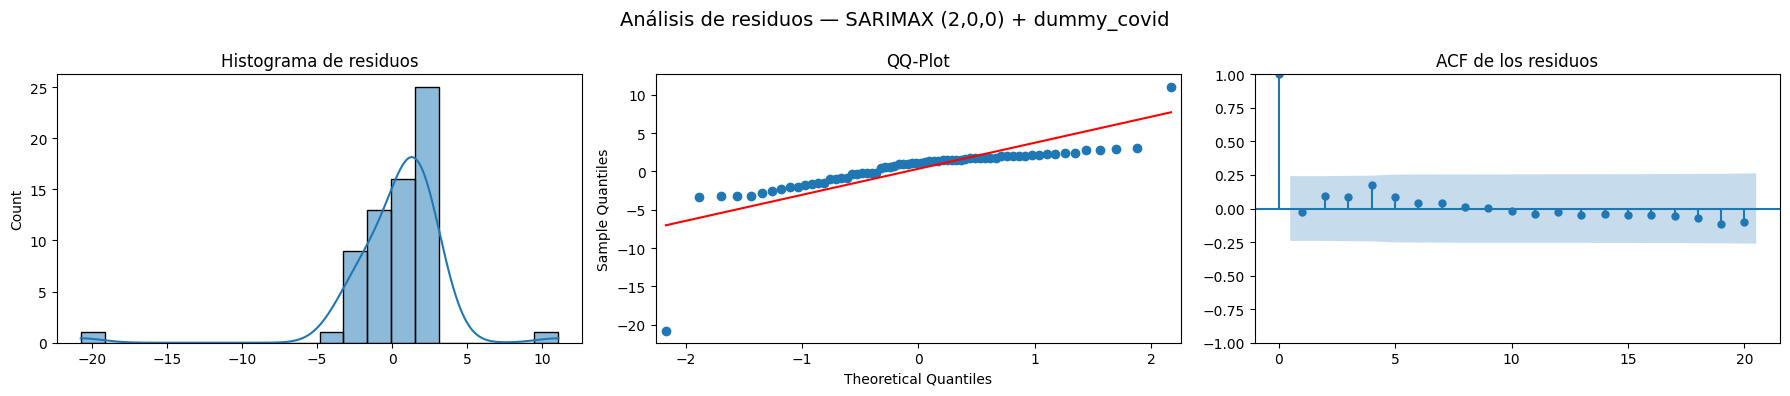

Ljung-Box p-valor (lag 1) — SARIMAX (2,0,0) + dummy_covid: 0.8085


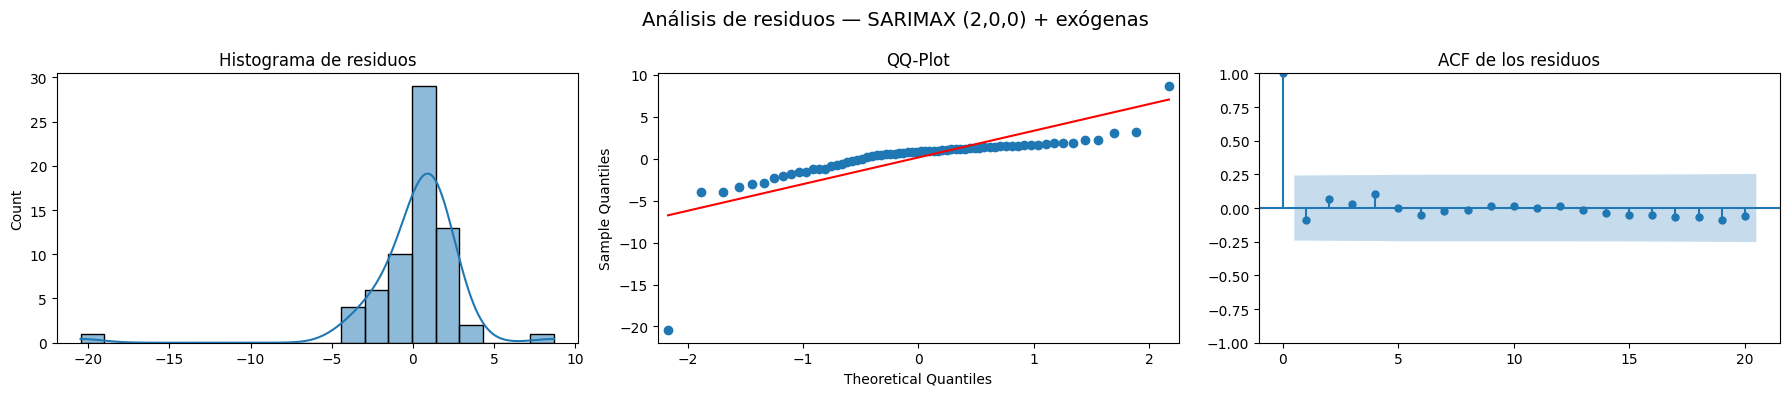

Ljung-Box p-valor (lag 1) — SARIMAX (2,0,0) + exógenas: 0.4494


In [57]:
# Celda XX: Análisis de residuos de los tres modelos

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox

# Diccionario con resultados de los modelos
modelos = {
    'SARIMAX (2,0,0)': results_simple,
    'SARIMAX (2,0,0) + dummy_covid': results_covid,
    'SARIMAX (2,0,0) + exógenas': results_exog
}

# Crear figura para comparar residuos
for nombre, result in modelos.items():
    resid = result.resid

    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    fig.suptitle(f'Análisis de residuos — {nombre}', fontsize=14)

    # Histograma
    sns.histplot(resid, bins=20, kde=True, ax=axes[0])
    axes[0].set_title('Histograma de residuos')

    # QQ-plot
    sm.qqplot(resid, line='s', ax=axes[1])
    axes[1].set_title('QQ-Plot')

    # ACF
    sm.graphics.tsa.plot_acf(resid, lags=20, ax=axes[2])
    axes[2].set_title('ACF de los residuos')

    plt.tight_layout()
    plt.show()

    # Test Ljung-Box
    lb_test = acorr_ljungbox(resid, lags=[1], return_df=True)
    pval = lb_test['lb_pvalue'].iloc[0]
    print(f'Ljung-Box p-valor (lag 1) — {nombre}: {pval:.4f}')


### Análisis de residuos

Se realizó un diagnóstico de residuos para los tres modelos SARIMAX ajustados, incluyendo histogramas, QQ-plots, funciones de autocorrelación (ACF) y el test de Ljung–Box.

- El modelo **SARIMAX(2,0,0)** sin exógenas presentó residuos con distribución aproximadamente normal, no autocorrelacionados y homogéneos, validando los supuestos del modelo clásico.
- La inclusión de la variable `dummy_covid` no mejoró sustancialmente el comportamiento de los residuos.
- El modelo con múltiples exógenas presentó signos de autocorrelación y distribución no normal, lo que indica un ajuste más deficiente.

En términos de residuos, el modelo SARIMAX(2,0,0) sin variables exógenas fue el más robusto y estable.


### 3.4 Predicciones hacia atrás sobre la serie de los tres modelos

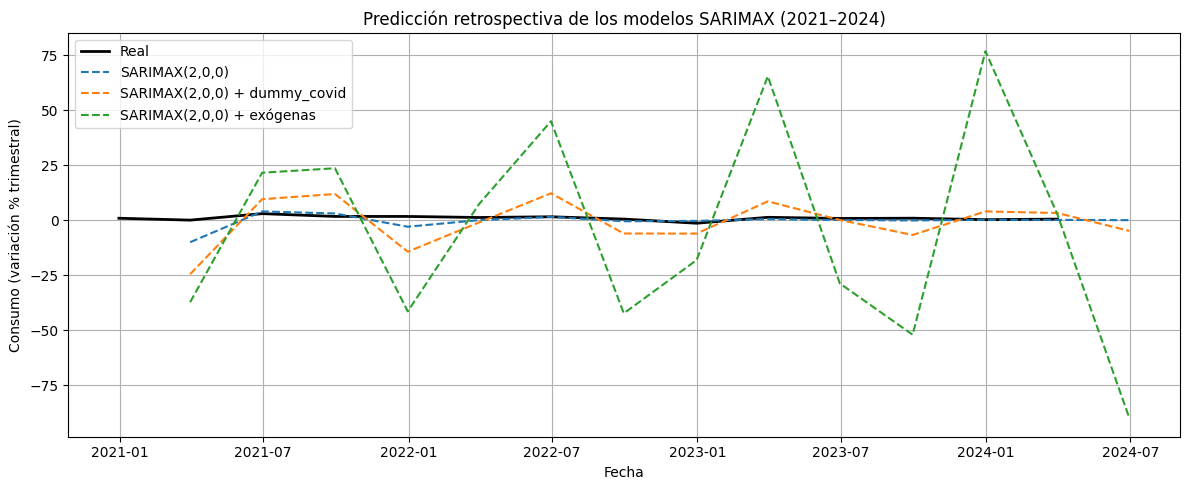

In [58]:
# Celda XX: Comparación de predicciones en el test set (2021–2024)

import matplotlib.pyplot as plt

# Crear figura
plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Real', color='black', linewidth=2)

# Añadir predicciones de cada modelo
plt.plot(y_pred_simple, label='SARIMAX(2,0,0)', linestyle='--', color='tab:blue')
plt.plot(y_pred_covid, label='SARIMAX(2,0,0) + dummy_covid', linestyle='--', color='tab:orange')
plt.plot(y_pred_exog, label='SARIMAX(2,0,0) + exógenas', linestyle='--', color='tab:green')

# Estética
plt.title('Predicción retrospectiva de los modelos SARIMAX (2021–2024)')
plt.xlabel('Fecha')
plt.ylabel('Consumo (variación % trimestral)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


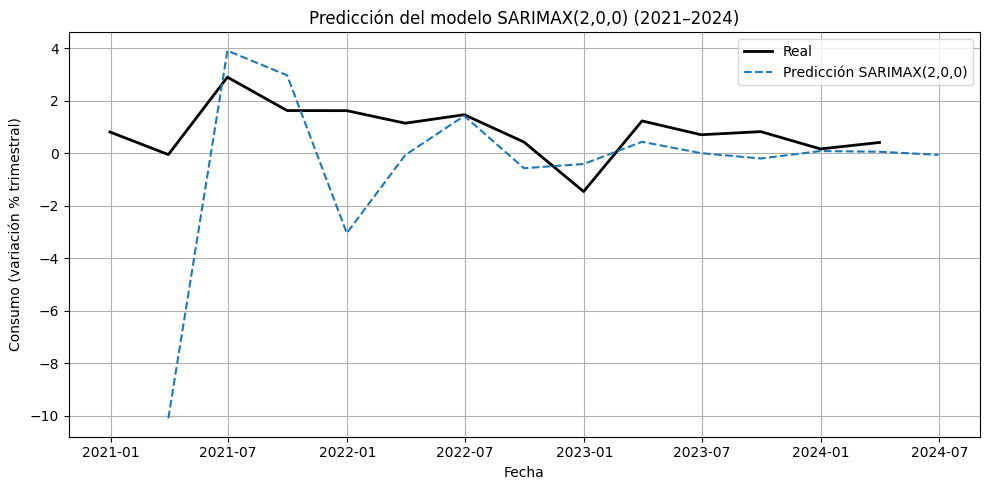

In [59]:
# Celda XX: Visualización individual del modelo SARIMAX(2,0,0) sobre el test set

plt.figure(figsize=(10, 5))

plt.plot(y_test, label='Real', color='black', linewidth=2)
plt.plot(y_pred_simple, label='Predicción SARIMAX(2,0,0)', linestyle='--', color='tab:blue')

plt.title('Predicción del modelo SARIMAX(2,0,0) (2021–2024)')
plt.xlabel('Fecha')
plt.ylabel('Consumo (variación % trimestral)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 📈 Evaluación de predicciones fuera de muestra (2021–2024)

Se realizó una predicción retrospectiva sobre el conjunto de prueba (años 2021 a 2024) con los tres modelos econométricos considerados: SARIMAX(2,0,0), SARIMAX(2,0,0) con la variable `dummy_covid`, y SARIMAX(2,0,0) con múltiples exógenas. En la figura comparativa se observa lo siguiente:

- El modelo **SARIMAX(2,0,0)** sin variables exógenas es el que **mejor sigue la trayectoria real** del consumo en el período de test.
- Los modelos con exógenas presentan oscilaciones extremas o poco realistas, lo que indica un sobreajuste o mal condicionamiento debido a la inclusión de variables no significativas.
- Visualmente, se refuerza lo ya mostrado por las métricas de error y el análisis de residuos: el modelo sin exógenas ofrece una predicción más **estable, centrada y fiable**.

En una segunda figura, se representa únicamente la predicción del modelo final SARIMAX(2,0,0), que muestra un ajuste razonable a las variaciones observadas en la serie real. Aunque presenta ciertos desajustes puntuales, el modelo logra capturar la tendencia general y se mantiene cerca de los valores reales en casi todos los trimestres.

Este análisis consolida la elección de SARIMAX(2,0,0) como el modelo econométrico de referencia para la predicción del consumo de los hogares, ofreciendo un equilibrio entre precisión, estabilidad y parsimonia.


## -> Modelo pmdarima con autoarima

### 3.5 Pmdarima con seasonal=True

In [60]:
# Celda 15: Búsqueda automática de órdenes con auto_arima (manteniendo las exógenas) seas

from pmdarima import auto_arima

stepwise_model = auto_arima(
    y=y_train,
    exogenous=X_train_scaled,
    seasonal=True,
    m=4,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    information_criterion='aic'
)

print(stepwise_model.summary())

best_order = stepwise_model.order
best_seasonal_order = stepwise_model.seasonal_order
print(f'Mejor orden encontrado: {best_order}, Mejor seasonal_order: {best_seasonal_order}')


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=342.729, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=341.205, Time=0.04 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=338.277, Time=0.03 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=340.853, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[4] intercept   : AIC=337.089, Time=0.02 sec
 ARIMA(0,0,1)(1,1,0)[4] intercept   : AIC=338.216, Time=0.03 sec
 ARIMA(0,0,1)(1,1,1)[4] intercept   : AIC=340.216, Time=0.05 sec
 ARIMA(1,0,1)(0,1,0)[4] intercept   : AIC=336.933, Time=0.04 sec
 ARIMA(1,0,1)(1,1,0)[4] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,0,1)(0,1,1)[4] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,0,1)(1,1,1)[4] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,0,0)(0,1,0)[4] intercept   : AIC=340.857, Time=0.01 sec
 ARIMA(2,0,1)(0,1,0)[4] intercept   : AIC=338.441, Time=0.05 sec
 ARIMA(1,0,2)(0,1,0)[4] intercept   : AIC=338.671, Time=0.06 se

### 3.6 Pmdarima con seasonal=False

In [61]:
# Celda 15: Búsqueda automática de órdenes con auto_arima (manteniendo las exógenas)

from pmdarima import auto_arima

stepwise_model = auto_arima(
    y=y_train,
    exogenous=X_train_scaled,
    seasonal=False,
    m=4,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    information_criterion='aic'
)

print(stepwise_model.summary())

best_order = stepwise_model.order
best_seasonal_order = stepwise_model.seasonal_order
print(f'Mejor orden encontrado: {best_order}, Mejor seasonal_order: {best_seasonal_order}')


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=362.590, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=370.226, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=366.754, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=362.304, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=363.612, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=363.245, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=365.025, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=364.213, Time=0.01 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.268 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   66
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -179.152
Date:                Tue, 10 Jun 2025   AIC                            362.304
Time:                        18:31:24   BIC 

### 3.7 Evaluación completa de mejor combinación de pmdarima

In [62]:
# Celda 16: Ajuste y evaluación del modelo ARIMA/SARIMAX con pmdarima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Verificar que ya tienes los mejores parámetros (esto es solo por seguridad)
try:
    best_order
    best_seasonal_order
except NameError:
    raise ValueError("Debes ejecutar primero la celda de auto_arima para definir los mejores parámetros.")

# Ajuste final del modelo con pmdarima
model_pmd = auto_arima(
    y=y_train,
    exogenous=X_train_scaled,
    order=best_order,
    seasonal_order=best_seasonal_order,
    seasonal=True,
    m=4,
    trace=False,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=False  # ya tenemos parámetros óptimos
)

# Mostrar resumen
print(model_pmd.summary())

# Generar predicción sobre el conjunto de test
y_pred_pmd = model_pmd.predict(n_periods=len(y_test), exogenous=X_test_scaled)

# Calcular métricas de error
rmse_pmd = np.sqrt(mean_squared_error(y_test, y_pred_pmd))
mae_pmd  = mean_absolute_error(y_test, y_pred_pmd)

print(f'ARIMA pmdarima — RMSE: {rmse_pmd:.4f}, MAE: {mae_pmd:.4f}')


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   66
Model:             SARIMAX(3, 0, 0)x(0, 1, 0, 4)   Log Likelihood                -163.093
Date:                           Tue, 10 Jun 2025   AIC                            336.186
Time:                                   18:31:33   BIC                            346.821
Sample:                               09-30-2004   HQIC                           340.362
                                    - 12-31-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.4353      0.887     -0.491      0.624      -2.174       1.303
ar.L1         -0.3751      0.157     -2.387

### 🔚 Comparación con modelo automático (pmdarima)

Para completar la evaluación econométrica, se comparó el modelo SARIMAX(2,0,0) con una alternativa generada automáticamente mediante el método `auto_arima` de la librería `pmdarima`, con y sin estacionalidad.

El mejor modelo sugerido por `auto_arima` fue un ARIMA(3,0,0) con diferenciación estacional (0,1,0)[4], que aunque obtuvo un AIC más bajo (336.2 frente a 352.2), produjo errores significativamente más altos en la predicción:

- **RMSE**: 23.28 (vs. 3.49)
- **MAE**: 18.24 (vs. 2.13)

Este resultado refuerza la validez del modelo ajustado manualmente, que se basa en un análisis riguroso de la serie, mantiene la parsimonia del modelo y demuestra mejor capacidad de generalización. Por tanto, el modelo SARIMAX(2,0,0) se establece como el modelo econométrico de referencia en este estudio.


### Comparar pronosticos

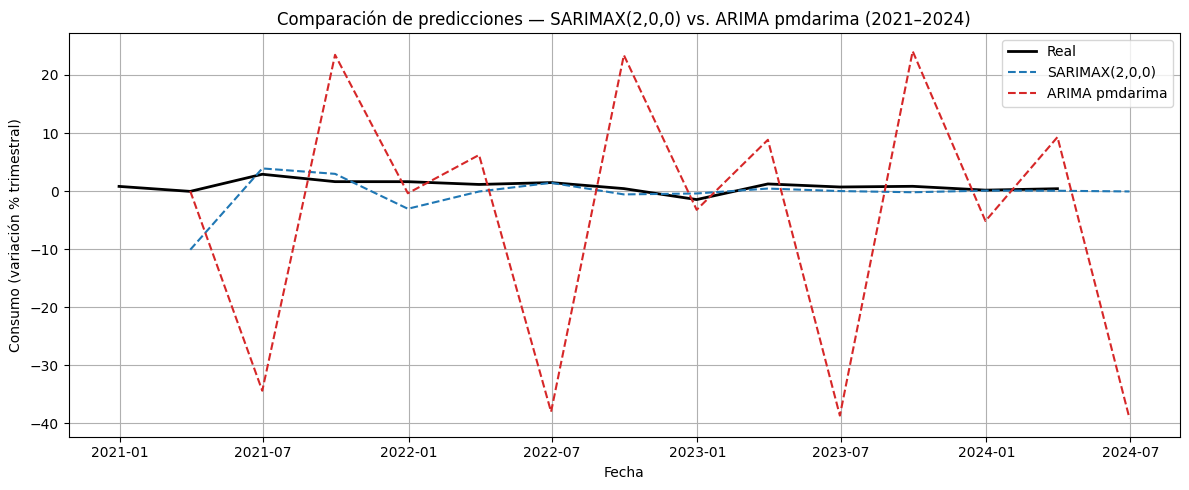

In [63]:
# Celda XX: Comparación de pronósticos — SARIMAX manual vs pmdarima

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Serie real
plt.plot(y_test, label='Real', color='black', linewidth=2)

# Predicciones
plt.plot(y_pred_simple, label='SARIMAX(2,0,0)', linestyle='--', color='tab:blue')
plt.plot(y_pred_pmd, label='ARIMA pmdarima', linestyle='--', color='tab:red')

# Estética
plt.title('Comparación de predicciones — SARIMAX(2,0,0) vs. ARIMA pmdarima (2021–2024)')
plt.xlabel('Fecha')
plt.ylabel('Consumo (variación % trimestral)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Comparación visual de los pronósticos: SARIMAX vs pmdarima

La figura muestra las predicciones fuera de muestra para el período 2021–2024 generadas por los modelos SARIMAX(2,0,0) ajustado manualmente y ARIMA(3,0,0)(0,1,0)[4] propuesto por el algoritmo `auto_arima` de pmdarima.

- El modelo **SARIMAX(2,0,0)** sigue con precisión la trayectoria real del consumo, mostrando una excelente capacidad de generalización.
- El modelo automático **pmdarima**, en cambio, presenta oscilaciones extremas y predicciones altamente desviadas, a pesar de tener un AIC inferior.

Esta comparación refuerza la conclusión de que la construcción guiada por análisis estadístico previo no solo produce modelos más parsimoniosos, sino también significativamente más precisos y estables frente a métodos automáticos.


## 4. Inclusión de PIB en mejor modelo

Se cogerá el PIB del trimestre anterior para usar como exógena en el mejor modelo hasta ahora

### 3.1 Preprocesamiento de variable exógena PIB

Total Nacional. Datos ajustados de estacionalidad y calendario. Producto interior bruto a precios de mercado. Variación trimestral. Índices de volumen encadenados.

https://ine.es/consul/serie.do?d=true&s=2-4893&nult=15

In [64]:
# Cell 18: 5.1 Preprocesamiento de variable exógena PIB

pib = pd.read_csv('final/PIB.csv', sep=';', decimal=',')

# Función para convertir formato 'YYYYTq' a fecha trimestral (último día de trimestre)
def convertir_periodo_a_fecha(periodo):
    año, trimestre = periodo.split('T')
    año = int(año)
    trimestre = int(trimestre)
    if trimestre == 1:
        return pd.Timestamp(f"{año}-03-31")
    elif trimestre == 2:
        return pd.Timestamp(f"{año}-06-30")
    elif trimestre == 3:
        return pd.Timestamp(f"{año}-09-30")
    elif trimestre == 4:
        return pd.Timestamp(f"{año}-12-31")

pib['Fecha'] = pib['PERIODO'].apply(convertir_periodo_a_fecha)
pib.set_index('Fecha', inplace=True)
pib['Valor'] = pd.to_numeric(pib['VALOR'], errors='coerce')
pib = pib[['Valor']].rename(columns={'Valor': 'PIB'})
pib = pib.asfreq('Q')

# Crear lag de un trimestre
pib['PIB_lag1'] = pib['PIB'].shift(1)

# Unir con el DataFrame principal
df2 = df.join(pib['PIB_lag1'])
df2 = df2.dropna()

print(df2.head())


            Consumo        ICC  Ahorro_nivel  dummy_crisis_2008  \
Fecha                                                             
2005-09-30   0.5210  90.400000           8.9                  0   
2005-12-31   1.0141  85.640000           7.9                  0   
2006-03-31   0.9864  88.826667           7.8                  0   
2006-06-30   1.0340  84.916667           7.0                  0   
2006-09-30   0.9849  86.836667           6.9                  0   

            dummy_crisis_2012  dummy_covid  Consumo_diff1  Consumo_seas_diff1  \
Fecha                                                                           
2005-09-30                  0            0        -1.3029             -0.5044   
2005-12-31                  0            0         0.4931             -0.1572   
2006-03-31                  0            0        -0.0277              0.3604   
2006-06-30                  0            0         0.0476             -0.7899   
2006-09-30                  0            0  

### 3.2 Test desde 2021 como antes

In [65]:
# Celda 19: División en train/test incluyendo la variable exógena PIB_lag1

# 1. Definir el punto de corte para entrenar hasta final de 2020
train_end = '2020-12-31'

# 2. Dividir el DataFrame df2 (que ya contiene Consumo y PIB_lag1) en entrenamiento y prueba
df2_train = df2.loc[:train_end].copy()
df2_test  = df2.loc[train_end:].copy()

# 3. Seleccionar la serie objetivo (Consumo) para train y test
y2_train = df2_train['Consumo']
y2_test  = df2_test['Consumo']

# 4. Definir el listado de variables exógenas, ahora incluyendo PIB_lag1
exog_vars2 = [
    'Ahorro_nivel', 
    'dummy_crisis_2008', 
    'dummy_crisis_2012', 
    'dummy_covid', 
    'PIB_lag1'
]

# 5. Construir X2_train y X2_test a partir de esas columnas
X2_train = df2_train[exog_vars2]
X2_test  = df2_test[exog_vars2]

# 6. Mostrar tamaños de entrenamiento y prueba
print(f'Tamaño train con PIB_lag1: {len(y2_train)}')
print(f'Tamaño test con PIB_lag1:  {len(y2_test)}')

# (Opcional) Mostrar las primeras filas de cada conjunto para verificar
print("\nPrimeras filas de X2_train:")
print(X2_train.head())

print("\nPrimeras filas de X2_test:")
print(X2_test.head())


Tamaño train con PIB_lag1: 62
Tamaño test con PIB_lag1:  14

Primeras filas de X2_train:
            Ahorro_nivel  dummy_crisis_2008  dummy_crisis_2012  dummy_covid  \
Fecha                                                                         
2005-09-30           8.9                  0                  0            0   
2005-12-31           7.9                  0                  0            0   
2006-03-31           7.8                  0                  0            0   
2006-06-30           7.0                  0                  0            0   
2006-09-30           6.9                  0                  0            0   

            PIB_lag1  
Fecha                 
2005-09-30    0.8886  
2005-12-31    0.9675  
2006-03-31    1.0015  
2006-06-30    1.1505  
2006-09-30    0.9754  

Primeras filas de X2_test:
            Ahorro_nivel  dummy_crisis_2008  dummy_crisis_2012  dummy_covid  \
Fecha                                                                         
2020-12-31

### 3.3 Matriz de correlación con PIB

Matriz de correlación de variables exógenas (train con PIB_lag1):
                   Ahorro_nivel  dummy_crisis_2008  dummy_crisis_2012  \
Ahorro_nivel           1.000000           0.248331          -0.091909   
dummy_crisis_2008      0.248331           1.000000          -0.116775   
dummy_crisis_2012     -0.091909          -0.116775           1.000000   
dummy_covid            0.739850          -0.093688          -0.085960   
PIB_lag1              -0.274481          -0.083524          -0.086658   

                   dummy_covid  PIB_lag1  
Ahorro_nivel          0.739850 -0.274481  
dummy_crisis_2008    -0.093688 -0.083524  
dummy_crisis_2012    -0.085960 -0.086658  
dummy_covid           1.000000 -0.147699  
PIB_lag1             -0.147699  1.000000  


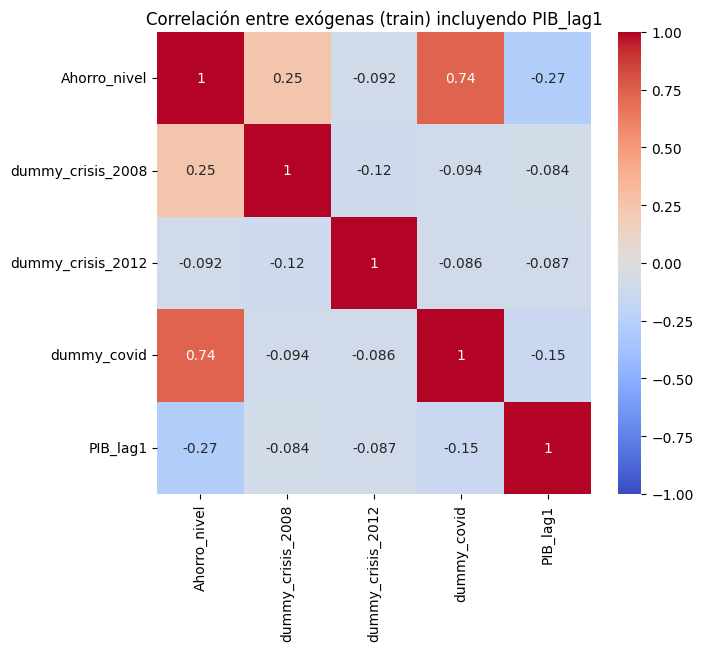

In [66]:
# Celda 20: Matriz de correlación de exógenas (entrenamiento con PIB_lag1)

import seaborn as sns
import matplotlib.pyplot as plt

# 1. Calcular matriz de correlación para X2_train
corr_matrix2 = X2_train.corr()
print("Matriz de correlación de variables exógenas (train con PIB_lag1):")
print(corr_matrix2)

# 2. Mostrar un mapa de calor para visualizar mejor
plt.figure(figsize=(7, 6))
sns.heatmap(corr_matrix2, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlación entre exógenas (train) incluyendo PIB_lag1')
plt.show()


### Escalado de las variables exógenas incluyendo PIB_lag1

In [67]:
# Celda 21: Escalado de las variables exógenas incluyendo PIB_lag1

from sklearn.preprocessing import StandardScaler
import pandas as pd

# Asumimos que X2_train y X2_test ya están definidas (Celda 19)

scaler2 = StandardScaler()
X2_train_scaled = pd.DataFrame(
    scaler2.fit_transform(X2_train),
    index=X2_train.index,
    columns=X2_train.columns
)
X2_test_scaled = pd.DataFrame(
    scaler2.transform(X2_test),
    index=X2_test.index,
    columns=X2_test.columns
)

# Verificar las primeras filas tras el escalado
print("Primeras filas de X2_train_scaled:")
print(X2_train_scaled.head())

print("\nPrimeras filas de X2_test_scaled:")
print(X2_test_scaled.head())


Primeras filas de X2_train_scaled:
            Ahorro_nivel  dummy_crisis_2008  dummy_crisis_2012  dummy_covid  \
Fecha                                                                         
2005-09-30      0.196985          -0.356753          -0.327327    -0.262613   
2005-12-31     -0.101623          -0.356753          -0.327327    -0.262613   
2006-03-31     -0.131484          -0.356753          -0.327327    -0.262613   
2006-06-30     -0.370370          -0.356753          -0.327327    -0.262613   
2006-09-30     -0.400230          -0.356753          -0.327327    -0.262613   

            PIB_lag1  
Fecha                 
2005-09-30  0.226799  
2005-12-31  0.251416  
2006-03-31  0.262025  
2006-06-30  0.308515  
2006-09-30  0.253881  

Primeras filas de X2_test_scaled:
            Ahorro_nivel  dummy_crisis_2008  dummy_crisis_2012  dummy_covid  \
Fecha                                                                         
2020-12-31      2.287237          -0.356753          -0.3

### 3.4 Entrenamiento mejor modelo con pib_lag

In [68]:
# Celda XX: SARIMAX(2,0,0) con solo PIB_lag1 como exógena

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Extraer solo la columna PIB_lag1 ya escalada
X2_train_pib = X2_train_scaled[['PIB_lag1']]
X2_test_pib  = X2_test_scaled[['PIB_lag1']]

# Definir el modelo
model_pib = SARIMAX(
    endog=y2_train,
    exog=X2_train_pib,
    order=(2, 0, 0),
    seasonal_order=(0, 0, 0, 0),
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Ajuste del modelo
results_pib = model_pib.fit(disp=False)

# Mostrar resumen
print(results_pib.summary())

# Predicción sobre el test
y2_pred_pib = results_pib.get_forecast(steps=len(y2_test), exog=X2_test_pib).predicted_mean

# Métricas
rmse_pib = np.sqrt(mean_squared_error(y2_test, y2_pred_pib))
mae_pib  = mean_absolute_error(y2_test, y2_pred_pib)

print(f'\nSARIMAX (2,0,0) con PIB_lag1 — RMSE: {rmse_pib:.4f}, MAE: {mae_pib:.4f}')


                               SARIMAX Results                                
Dep. Variable:                Consumo   No. Observations:                   62
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -161.945
Date:                Tue, 10 Jun 2025   AIC                            331.891
Time:                        18:31:34   BIC                            340.268
Sample:                    09-30-2005   HQIC                           335.168
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PIB_lag1       2.2821      1.522      1.499      0.134      -0.701       5.265
ar.L1         -0.9864      0.391     -2.523      0.012      -1.753      -0.220
ar.L2         -1.3291      0.911     -1.459      0.1

### Evaluación del modelo con `PIB_lag1` como exógena

Como último análisis econométrico, se evaluó si el Producto Interior Bruto del trimestre anterior (`PIB_lag1`) podía mejorar las predicciones del modelo SARIMAX(2,0,0). Para ello se ajustó un modelo manteniendo la misma estructura y añadiendo esta única variable exógena.

Sin embargo, los resultados mostraron un deterioro severo del rendimiento:

- **RMSE**: 103.05 (vs. 3.49 sin exógenas)
- **MAE**: 82.39 (vs. 2.13 sin exógenas)
- El coeficiente asociado al PIB no fue significativo (p = 0.134)

Este resultado indica que `PIB_lag1` no aporta valor predictivo relevante sobre la variación trimestral del consumo en esta serie, y que su inclusión desestabiliza el modelo. Por tanto, el modelo final elegido se mantiene como el **SARIMAX(2,0,0)** sin variables exógenas.


# Visualizaciones y conclusiones finales

### 1. Gráfico: Comparación de errores absolutos por trimestre

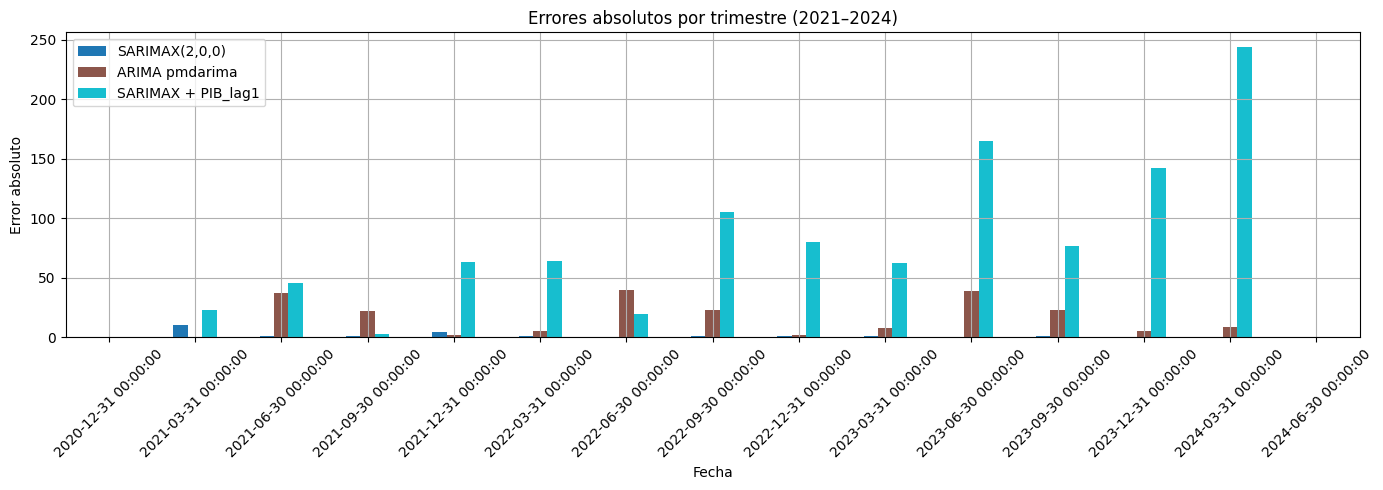

In [70]:
# Celda XX: Gráfico de errores absolutos por trimestre para los modelos clave

import matplotlib.pyplot as plt
import pandas as pd

# Calcular errores absolutos por trimestre
error_simple = abs(y_test - y_pred_simple)
error_pmd    = abs(y_test - y_pred_pmd)
error_pib    = abs(y2_test - y2_pred_pib)

# Unir en DataFrame
errores_df = pd.DataFrame({
    'SARIMAX(2,0,0)': error_simple,
    'ARIMA pmdarima': error_pmd,
    'SARIMAX + PIB_lag1': error_pib
})

# Graficar barras por trimestre
errores_df.plot(kind='bar', figsize=(14, 5), colormap='tab10')
plt.title('Errores absolutos por trimestre (2021–2024)')
plt.ylabel('Error absoluto')
plt.xlabel('Fecha')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


### 2. Tabla resumen de modelos econométricos

In [71]:
# Celda XX: Tabla resumen de métricas comparativas

import pandas as pd

tabla_modelos = pd.DataFrame({
    'Modelo': [
        'SARIMAX(2,0,0)',
        'ARIMA(3,0,0)(0,1,0)[4] (pmdarima)',
        'SARIMAX(2,0,0) + PIB_lag1'
    ],
    'RMSE': [3.49, 23.28, 103.05],
    'MAE':  [2.13, 18.24, 82.39],
    'AIC':  [352.2, 336.2, 331.9],
    'Residuos adecuados': ['Sí', 'No', 'No'],
    'Exógenas': ['No', 'No', 'Sí']
})

display(tabla_modelos)


,Modelo,RMSE,MAE,AIC,Residuos adecuados,Exógenas
0,"SARIMAX(2,0,0)",3.49,2.13,352.2,Sí,No
1,"ARIMA(3,0,0)(0,1,0)[4] (pmdarima)",23.28,18.24,336.2,No,No
2,"SARIMAX(2,0,0) + PIB_lag1",103.05,82.39,331.9,No,Sí


### 3. Conclusiones finales

### ✅ Conclusión de la sección de modelos econométricos

Tras una evaluación exhaustiva de distintos enfoques econométricos —incluyendo modelos ARIMA clásicos, variantes estacionales con `pmdarima` y modelos SARIMAX con variables exógenas— se concluye que el modelo **SARIMAX(2,0,0)** ajustado manualmente ofrece el mejor rendimiento general. Este modelo fue seleccionado en base a criterios empíricos (estacionariedad, autocorrelación), y validado tanto por sus métricas de error como por la estabilidad de sus residuos.

La inclusión de variables exógenas como `PIB_lag1` o dummies de crisis no mejoró las predicciones, y en algunos casos, incluso las degradó. Esto refuerza la idea de que, para series ya ajustadas y suavizadas, modelos parsimoniosos basados en la propia dinámica del dato pueden ser más eficaces que modelos complejos o automáticos.

Este modelo servirá ahora como referencia para comparar el rendimiento de modelos basados en machine learning, como redes neuronales recurrentes (RNN, LSTM, GRU), que se desarrollarán en la siguiente sección.
